# Dropout Prediction with SVD-Selected Predictors

Singular value decomposition (SVD) is the fact that any matrix $X\in\mathbb{R}^{m\times n}$ can be decomposed as
$$X = U\Sigma V^T$$
where $U\in\mathbb{R}^{m\times m}, V^T\in\mathbb{R}^{n\times n}$ are orthogonal matrices of orthonormal basis vectors, and $\Sigma\in\mathbb{R}^{m\times n}$ is a diagonal matrix of singular values $\sigma_1 \geq \ldots \geq \sigma_r\geq 0$, where $r$ is the rank of matrix $X$. Since $U$ and $V^T$ contain orthonormal vectors, they do not need to be scaled \citep{SVD}. Similar to principal component analysis, the proportion of variance explained for $j$ out of $r$ components is modeled by $\frac{\sum_{i=1}^j \sigma_i}{\sum_{i=1}^r \sigma_i}$. I will choose $j\in\mathbb{Z}^+$ such that 95\% of the data's variance is explained. Then the $j$-dimensional representation of the data will be multiplying the matrix of the first $j$ column vectors of $U$ with the $j\times j$ matrix of the first $j$ singular values.

Both ensemble and baseline machine learning models are used to predict whether a given student dropped out, is enrolled, or graduated from a degree program. The ensemble models are random forest and AdaBoost. A decision tree, support vector machine (SVM), k-nearest neighbors (KNN), and logistic regression model is each fit, as well.

5-fold cross validation is used to optimally tune the hyperparameters of each model.

The performance of each classification model is measured by the following metrics: accuracy, precision (conditional probability of the model correctly classifying a point given the true classification), recall (true positive rate), and F1 score (harmonic average of precision and recall, a measure of how balanced precision and recall are). Calculation of each of these metrics were done using scikit-learn's metrics module in Python. The precision, recall, and F1 score are weighted due to the imbalance of the response variable.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

In [2]:
df = pd.read_csv("data.csv", delimiter=";")
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [3]:
df.drop(columns=["Previous qualification"], inplace=True)

In [4]:
categorical_cols = ["Mother\'s qualification", "Father\'s qualification","Mother\'s occupation", "Father\'s occupation",\
                    "Marital status", "Nacionality", "Application mode", "Course", "Gender", "Displaced", "Educational special needs",\
                    "Debtor", "Tuition fees up to date", "Scholarship holder", "International", "Daytime/evening attendance\t"]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded["Target"] = df["Target"].map({"Dropout": 0, "Enrolled": 1, "Graduate": 2})

df_encoded.head()

,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),...,Course_9853,Course_9991,Gender_1,Displaced_1,Educational special needs_1,Debtor_1,Tuition fees up to date_1,Scholarship holder_1,International_1,Daytime/evening attendance\t_1
0,5,122.0,127.3,20,0,0,0,0,0.000000,0,...,False,False,True,True,False,False,True,False,False,True
1,1,160.0,142.5,19,0,6,6,6,14.000000,0,...,False,False,True,True,False,False,False,False,False,True
2,5,122.0,124.8,19,0,6,0,0,0.000000,0,...,False,False,True,True,False,False,False,False,False,True
3,2,122.0,119.6,20,0,6,8,6,13.428571,0,...,False,False,False,True,False,False,True,False,False,True
4,1,100.0,141.5,45,0,6,9,5,12.333333,0,...,False,False,False,False,False,False,True,False,False,False


In [5]:
# separate into X and y values
X = df_encoded.drop(columns="Target")
y = df_encoded["Target"]

# Singular Value Decomposition

In [6]:
U, S, VT = np.linalg.svd(X.astype(float))

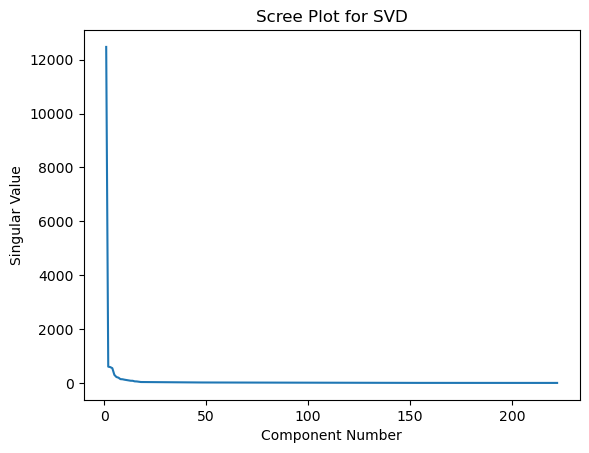

In [7]:
# scree plot
plt.plot(np.arange(1, len(S) + 1), S)
plt.xlabel("Component Number")
plt.ylabel("Singular Value")
plt.title("Scree Plot for SVD")
plt.show()

In [8]:
prop_var_explained = np.cumsum(S)/np.sum(S)

By our scree plot, it is apparent that 36 SVD predictors preserves 95% of the variance in the data. And so each classification model will be trained with 36 predictors.

In [9]:
n_components = np.where(prop_var_explained > 0.95)[0][0]
n_components+1

36

In [10]:
# transformed data
X_reduced = U[:, :n_components]@np.diag(S[:n_components])

In [11]:
np.random.seed(1) # for reproducibility

# 5-fold cross validation
cv = KFold(n_splits=5, shuffle=True)

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, shuffle=True)

# clearly unbalanced responses, so will set class weights
class_weights = {c: 1.0/np.sum(y_train == c) for c in np.unique(y_train)}

# Random Forest

In [12]:
np.random.seed(1) # for reproducibility

# 5-fold CV grid search
rf_params = {"n_estimators": range(100, 400, 100), "warm_start": [True, False]}
rf_gs = GridSearchCV(RandomForestClassifier(class_weight=class_weights), param_grid=rf_params, cv=cv).fit(X_train, y_train)

# fit random forest model and make predictions
rf_model = RandomForestClassifier(**rf_gs.best_params_, class_weight=class_weights).fit(X_train, y_train)
predictions = rf_model.predict(X_test)

# performance metrics
print("Random Forest")
print(f"Accuracy: {accuracy_score(predictions, y_test)}\nPrecision: {precision_score(predictions, y_test, average='weighted')}")
print(f"Recall: {recall_score(predictions, y_test, average='weighted')}\nF1 Score: {f1_score(predictions, y_test, average='weighted')}")

Random Forest
Accuracy: 0.7435028248587571
Precision: 0.8358510039715734
Recall: 0.7435028248587571
F1 Score: 0.7769336914794144


# AdaBoost

In [13]:
np.random.seed(1) # for reproducibility

# 5-fold CV grid search
adaboost_params = {"n_estimators": range(100, 400, 100), "learning_rate": np.arange(0.001, 10, 100)}
adaboost_gs = GridSearchCV(AdaBoostClassifier(algorithm="SAMME"), param_grid=adaboost_params, cv=cv).fit(X_train, y_train)

# fit AdaBoost model and make predictions
adaboost_model = AdaBoostClassifier(**adaboost_gs.best_params_, algorithm="SAMME").fit(X_train, y_train)
predictions = adaboost_model.predict(X_test)

# performance metrics
print("AdaBoost")
print(f"Accuracy: {accuracy_score(predictions, y_test)}\nPrecision: {precision_score(predictions, y_test, average='weighted')}")
print(f"Recall: {recall_score(predictions, y_test, average='weighted')}\nF1 Score: {f1_score(predictions, y_test, average='weighted')}")

AdaBoost
Accuracy: 0.6338983050847458
Precision: 0.8593402569958304
Recall: 0.6338983050847458
F1 Score: 0.7105380800828954


c:\Users\tydav\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Classification Tree

In [ ]:
np.random.seed(1) # for reproducibility

# fit tree model and make predictions
cart_model = DecisionTreeClassifier(class_weight=class_weights).fit(X_train, y_train)
predictions = cart_model.predict(X_test)

# performance metrics
print("Classification Tree")
print(f"Accuracy: {accuracy_score(predictions, y_test)}\nPrecision: {precision_score(predictions, y_test, average='weighted')}")
print(f"Recall: {recall_score(predictions, y_test, average='weighted')}\nF1 Score: {f1_score(predictions, y_test, average='weighted')}")

Classification Tree
Accuracy: 0.6519774011299435
Precision: 0.665084454374685
Recall: 0.6519774011299435
F1 Score: 0.6578510277582306


# Support Vector Machine

In [ ]:
np.random.seed(1) # for reproducibility

# 5-fold CV grid search
svm_params = {"kernel": ["linear", "poly", "rbf"]}
svm_gs = GridSearchCV(SVC(class_weight=class_weights), param_grid=svm_params, cv=cv).fit(X_train, y_train)

# fit SVM model and make predictions
svm_model = SVC(**svm_gs.best_params_).fit(X_train, y_train)
predictions = svm_model.predict(X_test)

# performance metrics
print("Support Vector Machine")
print(f"Accuracy: {accuracy_score(predictions, y_test)}\nPrecision: {precision_score(predictions, y_test, average='weighted')}")
print(f"Recall: {recall_score(predictions, y_test, average='weighted')}\nF1 Score: {f1_score(predictions, y_test, average='weighted')}")

Support Vector Machine
Accuracy: 0.7593220338983051
Precision: 0.8130631928728919
Recall: 0.7593220338983051
F1 Score: 0.7777230742695982


# k-Nearest Neighbors

In [ ]:
np.random.seed(1) # for reproducibility

# 5-fold CV grid search
knn_params = {"n_neighbors": range(3, 31, 2), "metric": ["manhattan", "cosine", "euclidean"]}
knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid=knn_params, cv=cv).fit(X_train, y_train)

# fit KNN model and make predictions
knn_model = KNeighborsClassifier(**knn_gs.best_params_).fit(X_train, y_train)
predictions = knn_model.predict(X_test)

# performance metrics
print("k-Nearest Neighbors")
print(f"Accuracy: {accuracy_score(predictions, y_test)}\nPrecision: {precision_score(predictions, y_test, average='weighted')}")
print(f"Recall: {recall_score(predictions, y_test, average='weighted')}\nF1 Score: {f1_score(predictions, y_test, average='weighted')}")

k-Nearest Neighbors
Accuracy: 0.7152542372881356
Precision: 0.8262693042537782
Recall: 0.7152542372881356
F1 Score: 0.7493012193259624


# Logistic Regression

In [ ]:
np.random.seed(1) # for reproducibility

warnings.filterwarnings("ignore")

# 5-fold CV grid search
lreg_params = {"solver": ["lbgfs", "liblinear", "saga", "sag", "newton-cholesky"]}
lreg_gs = GridSearchCV(LogisticRegression(class_weight=class_weights), param_grid=lreg_params, cv=cv).fit(X_train, y_train)

# fit logistic regression model and make predictions
lreg_model = LogisticRegression(**lreg_gs.best_params_).fit(X_train, y_train)
predictions = lreg_model.predict(X_test)

# performance metrics
print("Logistic Regression")
print(f"Accuracy: {accuracy_score(predictions, y_test)}\nPrecision: {precision_score(predictions, y_test, average='weighted')}")
print(f"Recall: {recall_score(predictions, y_test, average='weighted')}\nF1 Score: {f1_score(predictions, y_test, average='weighted')}")

Logistic Regression
Accuracy: 0.7638418079096045
Precision: 0.8444778551806978
Recall: 0.7638418079096045
F1 Score: 0.7940017949248003


Interestingly, in terms of accuracy, recall, and F1 score, none of the ensemble methods performed the best. AdaBoost however did perform the best in terms of precision.

Logistic regression performed the best in terms of accuracy, recall, and F1 score. 

Using the SVD predictors, logistic regression would be the best classification model due to its predictive power and ability to minimize the number of incorrectly classified points since it has the best balance of precision and recall. This is very important metric for the classification imbalances we have, as seen in the EDA file.